## Instructions
- Load the dataset and explore the variables.
- We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.
- Split the Dataset into X ('tenure', 'SeniorCitizen', 'MonthlyCharges') and y ('Churn')
- Build the logistic regression model.
- Evaluate the model.
- Even a simple model will give us more than 70% accuracy. Why?
- Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [248]:
# Loading and checking dataset

df = pd.read_csv('files_for_lab/customer_churn.csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data cleaning

In [249]:
# Checking data types

df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [250]:
# Checking for nulls

df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [251]:
# Checking for duplicates

df.duplicated().sum()

0

In [252]:
# df_categorical = df.select_dtypes(include='object')

for col in df.select_dtypes(include='object'):
    print(col, '-', df[col].unique(), '\n')

customerID - ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

gender - ['Female' 'Male'] 

Partner - ['Yes' 'No'] 

Dependents - ['No' 'Yes'] 

PhoneService - ['No' 'Yes'] 

MultipleLines - ['No phone service' 'No' 'Yes'] 

InternetService - ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity - ['No' 'Yes' 'No internet service'] 

OnlineBackup - ['Yes' 'No' 'No internet service'] 

DeviceProtection - ['No' 'Yes' 'No internet service'] 

TechSupport - ['No' 'Yes' 'No internet service'] 

StreamingTV - ['No' 'Yes' 'No internet service'] 

StreamingMovies - ['No' 'Yes' 'No internet service'] 

Contract - ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling - ['Yes' 'No'] 

PaymentMethod - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

TotalCharges - ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5'] 

Churn - ['No' 'Yes'] 



- CustomerID is a unique identifier and will be removed later.
- TotalCharges should be a float
- There are several cols with only 'Yes' and 'No' options, they will be replaced by 1 and 0 respectively
- Rest of the columns seem to be categorical nominal and will be one hot encoded
- You could make a case of contract being ordinal but for the sake of simplicity it will be considered nominal

In [253]:
# Replacing Yes and No from binary categorical cols with 1 and 0

yes_no_cols = [col for col in df.columns if set(df[col].unique()) == {'Yes', 'No'}]

print(yes_no_cols)

mapping = {'Yes': 1, 'No': 0}

df[yes_no_cols] = df[yes_no_cols].replace(mapping)

df

['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,1,1,24,1,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,1,Mailed check,84.80,1990.5,0
7039,2234-XADUH,Female,0,1,1,72,1,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,1,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,Female,0,1,1,11,0,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,1,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,1,0,4,1,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Mailed check,74.40,306.6,1


In [254]:
# Cleaning TotalCharges column

df['TotalCharges'] = df['TotalCharges'].replace(r' +', np.nan, regex=True)

spaces = df['TotalCharges'].str.isspace().sum()
print(f'Number of spaces: {spaces}')

nans = df['TotalCharges'].isna().sum()
print(f'Number of NaNs: {nans}')

df['TotalCharges'] = df['TotalCharges'].apply(lambda x: float(x))

Number of spaces: 0
Number of NaNs: 11


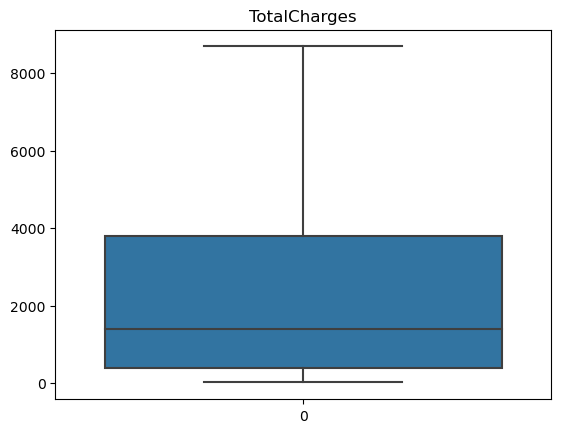

In [255]:
sns.boxplot(df['TotalCharges'])
plt.title('TotalCharges')
plt.show()

In [256]:
# The mean could return higher values than expected so we will replace NaNs with the median

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df['TotalCharges'].isna().sum()

0

## EDA

In [257]:
# Exploring numerical cols

num = ['tenure', 'MonthlyCharges', 'TotalCharges']

df_num = df[num]

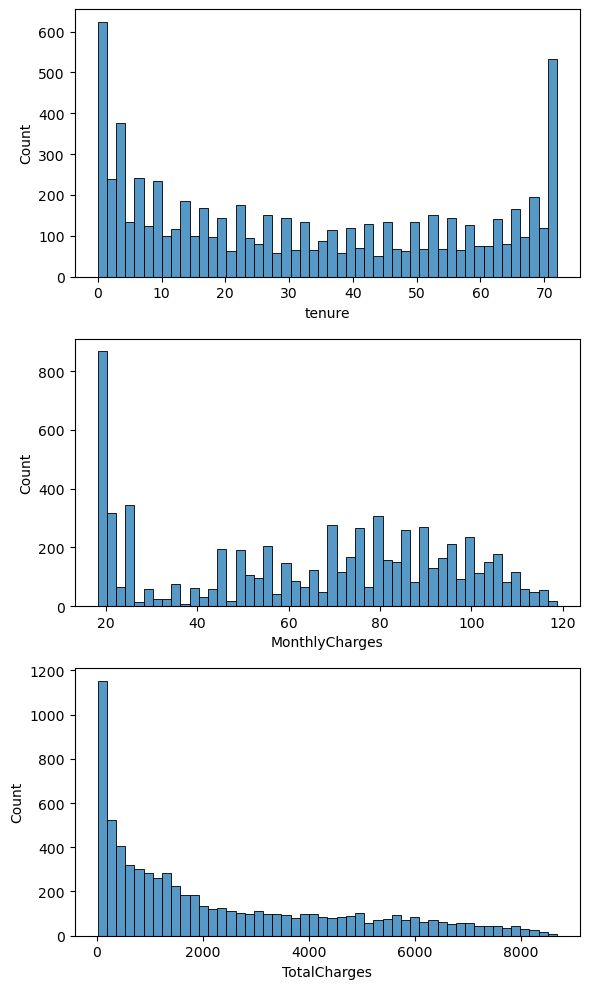

In [258]:
# Histograms

fig, axes = plt.subplots(3, 1, figsize=(6, 10))

for i, col in enumerate(df_num):
    sns.histplot(df_num[col], ax=axes[i], bins=50)

plt.tight_layout()

plt.show()

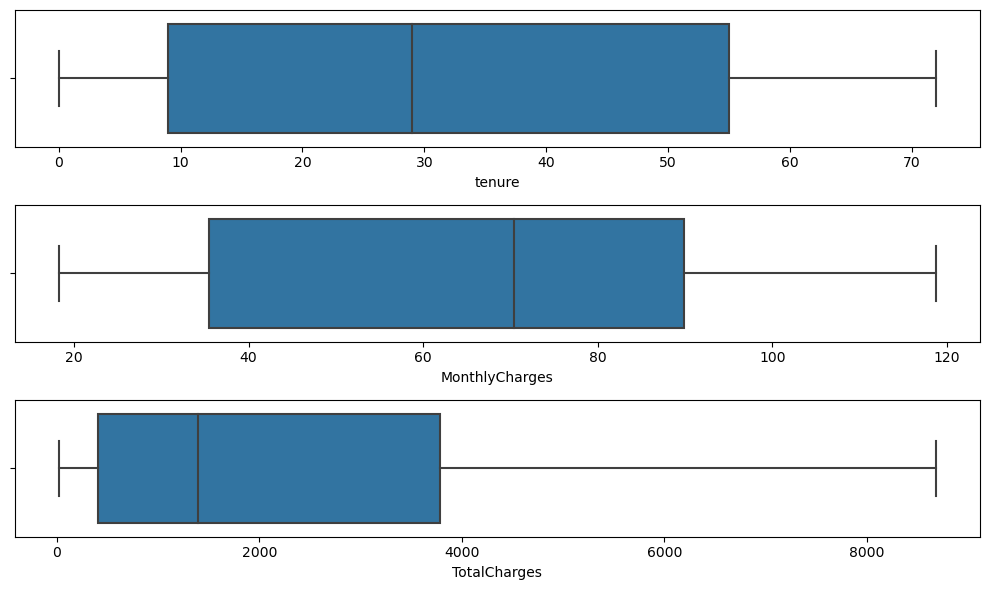

In [259]:
# Boxplots

fig, axes = plt.subplots(3, 1, figsize=(10, 6))

for i, col in enumerate(df_num):
    sns.boxplot(x=df_num[col], ax=axes[i])

plt.tight_layout()

plt.show()

In [260]:
# Calculating skewness

from scipy.stats import skew

df_num.skew()

tenure            0.239540
MonthlyCharges   -0.220524
TotalCharges      0.963789
dtype: float64

TotalCharges is a bit skewed but does not seem enough to warrant a transformation.

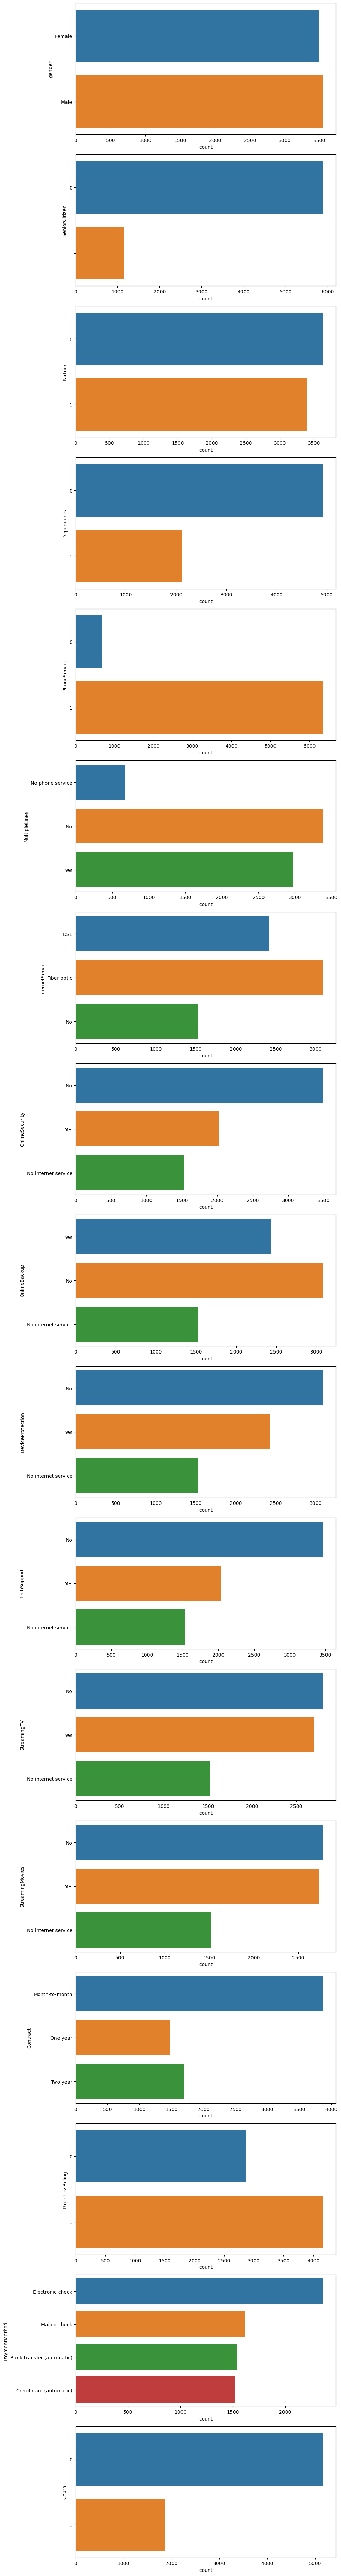

In [261]:
# Exploring categorical cols

cat = [col for col in df.columns if df[col].nunique() < 50]

df_cat = df[cat]

fig, axes = plt.subplots(17, 1, figsize=(10, 75))

for i, col in enumerate(df_cat):
    sns.countplot(y=df_cat[col], ax=axes[i])

plt.tight_layout()

plt.show()

There are no categories small enough to warrant grouping.

In [262]:
# Checking class balance of the target variable

df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

## Train-test split and preprocessing

Target variable is heavily imbalanced towards the 0 label.

In [263]:
# Splitting into X and y

y = df['Churn']

X = df[['tenure', 'SeniorCitizen', 'MonthlyCharges']]

In [264]:
# Train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [265]:
# Applying minmaxscaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

display(X_train_scaled.head())
display(X_test_scaled.head())

,tenure,SeniorCitizen,MonthlyCharges
2374,0.027778,0.0,0.011443
5908,0.013889,0.0,0.019403
6565,0.847222,0.0,0.875124
5724,0.013889,0.0,0.528358
2957,0.055556,0.0,0.617413


,tenure,SeniorCitizen,MonthlyCharges
416,0.972222,0.0,0.800498
4521,0.638889,0.0,0.271642
4213,0.083333,0.0,0.323881
1580,0.291667,1.0,0.531841
2226,0.319444,0.0,0.162687


## Creating model and getting predictions

In [266]:
# Logistic regression model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train_scaled, y_train)

y_test_pred = logreg.predict(X_test_scaled)
y_test_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Evaluating model performance

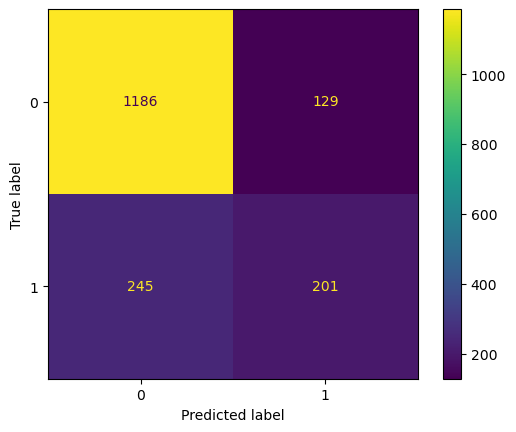

In [267]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=logreg.classes_)
cm_display.plot()
plt.show()

In [268]:
# Classification report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1315
           1       0.61      0.45      0.52       446

    accuracy                           0.79      1761
   macro avg       0.72      0.68      0.69      1761
weighted avg       0.77      0.79      0.78      1761



In [269]:
# Kappa score

from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, y_test_pred)

0.3857221202489144

- Scores a good for the label with most values but not so much for the other
- The Kappa score highlights the difficulty of our model to correctly predict the '1' label

## Using SMOTE to oversample our train data

In [270]:
# Oversampling with smote

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

(7718, 3)
(7718,)


In [271]:
# MinMaxScaler

scaler = MinMaxScaler()

X_train_resampled_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train_resampled.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [272]:
# Creating model and getting predictions

logreg = LogisticRegression()

logreg.fit(X_train_resampled_scaled, y_train_resampled)

y_test_pred = logreg.predict(X_test_scaled)
y_test_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

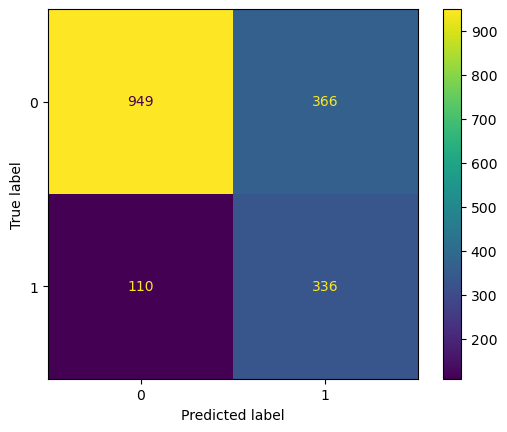

In [273]:
# Confusion matrix

cm = confusion_matrix(y_test, y_test_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=logreg.classes_)
cm_display.plot()
plt.show()

In [274]:
# Classification report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1315
           1       0.48      0.75      0.59       446

    accuracy                           0.73      1761
   macro avg       0.69      0.74      0.69      1761
weighted avg       0.79      0.73      0.75      1761



In [275]:
# Kappa score

cohen_kappa_score(y_test, y_test_pred)

0.39930516738758415

Seems like the model has improved a bit and is not able to correctly predict the '0' value a little more consistently, but the improvement is very marginal.